<a href="https://colab.research.google.com/github/Nicolas-Saade/TensorflowDeepImageNet/blob/test1/Transfer_Learning_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jun  8 17:50:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf

# Deep Learning API for creating Neural Networks (Runs on TensorFlow)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import math
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import pathlib
import os
import zipfile
import io
from google.colab import files

In [ ]:
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
for filename in uploaded.keys():
    print('Uploaded zip file:', filename)
    with zipfile.ZipFile(io.BytesIO(uploaded[filename]), 'r') as zip_ref:
        zip_ref.extractall('/content/')  # Extracting contents to /content/ directory
    print('Extraction complete.')

Uploaded zip file: 20FoodImages.zip
Extraction complete.


In [ ]:
# Function grabs a random image from a directory
def display_random_image(dir, class_type):
    # Define directory to look in
    img_dir = dir + "/" + class_type
    files = os.listdir(img_dir)
    img_name = random.choice(files)
    img = mpimg.imread(img_dir + "/" + img_name)
    plt.imshow(img)
    plt.title(class_type)
    plt.axis("off");
    print(f"Image shape: {img.shape}")

Image shape: (384, 512, 3)


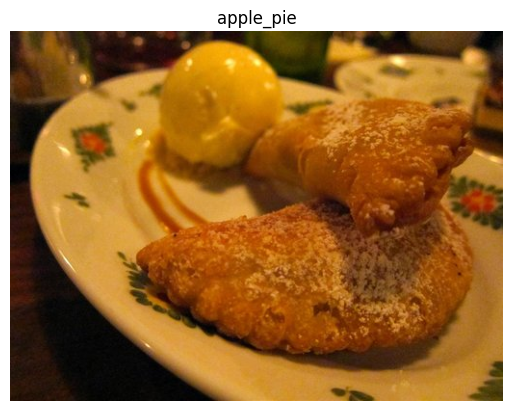

In [ ]:
display_random_image("/content/20FoodImages/train",
                    "apple_pie")

In [ ]:
# Setup train & test directories
train_dir = "/content/20FoodImages/train/"
validation_dir = "/content/20FoodImages/test/"

In [ ]:
# Normalize from RGB values from 0 to 255 to 0 to 1
train_IDG = ImageDataGenerator(rescale=1/255)
validation_IDG = ImageDataGenerator(rescale=1/255)

# Load data and turn it into batches
train_data = train_IDG.flow_from_directory(train_dir,
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode="categorical") # Multi-class instead of binary

val_data = validation_IDG.flow_from_directory(validation_dir,
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode="categorical")

Found 600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [ ]:
# Get the total number of batches of 32 images
len(train_data), 2400/32

(19, 75.0)

In [ ]:
# Create model
model_1 = Sequential([
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(3), #changing to 3 for now to test the model
    Activation(activation="softmax") # 20 output neurons
])

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data, # 20 classes
                        epochs=5,
                        steps_per_epoch=len(train_data), # Take enough steps to go through all batches
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
19/19 [==============================] - 15s 553ms/step - loss: 1.1307 - accuracy: 0.4317 - val_loss: 1.0230 - val_accuracy: 0.4504
Epoch 2/5
19/19 [==============================] - 9s 483ms/step - loss: 0.9297 - accuracy: 0.5400 - val_loss: 0.9016 - val_accuracy: 0.5233
Epoch 3/5
19/19 [==============================] - 9s 488ms/step - loss: 0.8055 - accuracy: 0.6583 - val_loss: 0.8711 - val_accuracy: 0.5746
Epoch 4/5
19/19 [==============================] - 8s 430ms/step - loss: 0.6665 - accuracy: 0.7633 - val_loss: 0.8228 - val_accuracy: 0.5879
Epoch 5/5
19/19 [==============================] - 9s 496ms/step - loss: 0.5110 - accuracy: 0.8217 - val_loss: 0.9432 - val_accuracy: 0.5550


In [ ]:
model_1.evaluate(val_data)

75/75 [==============================] - 7s 98ms/step - loss: 0.9432 - accuracy: 0.5550


[0.9432207345962524, 0.5550000071525574]

<Axes: >

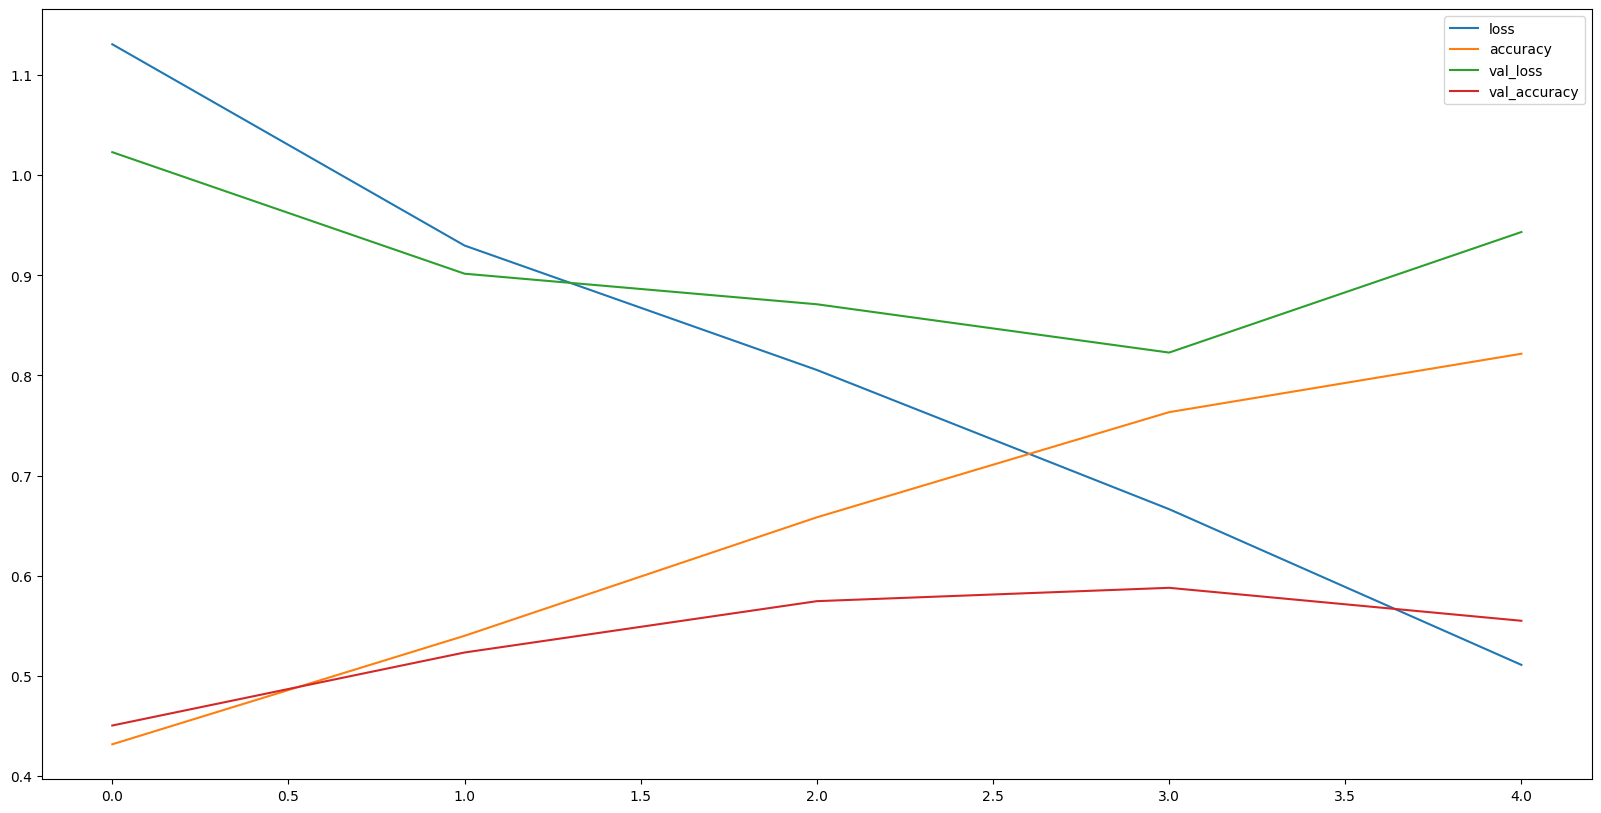

In [ ]:
# Plot loss and accuracy
pd.DataFrame(history_1.history).plot(figsize=(20, 10))

In [ ]:
# Augmenting this data doesn't change the images, but instead
# loads here when executed

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Create model
model_2 = Sequential([
    data_augmentation,
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(3), #keeping this at 3 for now
    Activation(activation="softmax") # 20 output neurons
])

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # 20 classes
                        epochs=5,
                        steps_per_epoch=len(train_data), # Take enough steps to go through all batches
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
19/19 [==============================] - 28s 1s/step - loss: 1.1353 - accuracy: 0.3717 - val_loss: 1.0701 - val_accuracy: 0.3625
Epoch 2/5
19/19 [==============================] - 13s 705ms/step - loss: 1.0353 - accuracy: 0.4050 - val_loss: 0.9533 - val_accuracy: 0.5475
Epoch 3/5
19/19 [==============================] - 8s 446ms/step - loss: 0.9111 - accuracy: 0.5583 - val_loss: 0.8495 - val_accuracy: 0.5871
Epoch 4/5
19/19 [==============================] - 8s 443ms/step - loss: 0.8366 - accuracy: 0.5483 - val_loss: 0.8737 - val_accuracy: 0.5708
Epoch 5/5
19/19 [==============================] - 9s 480ms/step - loss: 0.7812 - accuracy: 0.5867 - val_loss: 1.0418 - val_accuracy: 0.5475


In [ ]:
class_names = [d for d in os.listdir('/content/20FoodImages/train/') if not d.startswith('.')]
class_names.sort()  # making sure that directories are sorted/stored in the same way
class_names

['apple_pie', 'baby_back_ribs', 'baklava']

(-0.5, 511.5, 511.5, -0.5)

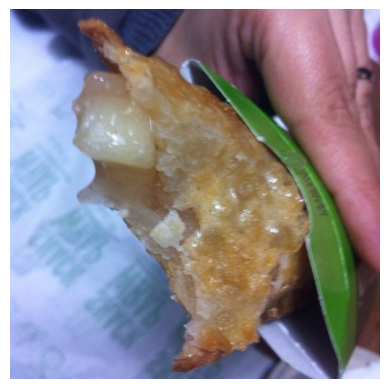

In [ ]:
apple_pie = mpimg.imread("/content/20FoodImages/test/apple_pie/1011328.jpg")
plt.imshow(apple_pie)
plt.axis(False)

In [ ]:
apple_pie.shape

(512, 512, 3)

In [ ]:
def normalize_and_resize(img_loc):
  my_img = tf.io.read_file(img_loc)
  my_img = tf.image.decode_image(my_img)
  my_img = tf.image.resize(my_img, size=[256, 256])

  my_img = my_img/255.
  return my_img

In [ ]:
apple_pie = normalize_and_resize("/content/20FoodImages/test/apple_pie/1011328.jpg")
apple_pie

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.39117646, 0.46960783, 0.74607843],
        [0.3137255 , 0.38431373, 0.65      ],
        [0.24901961, 0.3019608 , 0.55      ],
        ...,
        [0.7941176 , 0.845098  , 0.9823529 ],
        [0.79901963, 0.83431375, 0.9872549 ],
        [0.79607844, 0.83137256, 0.9843137 ]],

       [[0.4372549 , 0.5245098 , 0.8       ],
        [0.38333333, 0.45686275, 0.7264706 ],
        [0.28039217, 0.34215686, 0.595098  ],
        ...,
        [0.79607844, 0.84313726, 0.99215686],
        [0.7941176 , 0.84117645, 0.99019605],
        [0.7921569 , 0.8392157 , 0.99607843]],

       [[0.4852941 , 0.57843137, 0.85294116],
        [0.41568628, 0.50392157, 0.76960784],
        [0.33529413, 0.40392157, 0.6637255 ],
        ...,
        [0.79509807, 0.8421569 , 0.9911765 ],
        [0.7872549 , 0.8421569 , 0.99509805],
        [0.7852941 , 0.8362745 , 1.        ]],

       ...,

       [[0.5833333 , 0.65392154, 0.9127451 ],
        [0.57

In [ ]:
prediction = model_2.predict(tf.expand_dims(apple_pie, axis=0))
prediction #image probabilites

1/1 [==============================] - 0s 26ms/step


array([[0.43213072, 0.05989791, 0.5079714 ]], dtype=float32)

In [ ]:
class_names[np.argmax(prediction)]

'baklava'

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
# Download ResNet model and save as Keras layer
# Trainable : False means we don't want to train it further
resnet_layer = hub.KerasLayer(resnet_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
resnet_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    resnet_layer,
    # Define we will use 20 classes
    Dense(3,
        activation="softmax")
])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23570947 (89.92 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Compile resnet Model
resnet_model.compile(loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [ ]:
# Fit Transfer Learning Model
resnet_history = resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data)

Epoch 1/5
19/19 [==============================] - 24s 791ms/step - loss: 1.0936 - accuracy: 0.4717 - val_loss: 0.7189 - val_accuracy: 0.6904
Epoch 2/5
19/19 [==============================] - 11s 595ms/step - loss: 0.5627 - accuracy: 0.7733 - val_loss: 0.5394 - val_accuracy: 0.7892
Epoch 3/5
19/19 [==============================] - 10s 572ms/step - loss: 0.4163 - accuracy: 0.8467 - val_loss: 0.4929 - val_accuracy: 0.8046
Epoch 4/5
19/19 [==============================] - 10s 571ms/step - loss: 0.3367 - accuracy: 0.8967 - val_loss: 0.4630 - val_accuracy: 0.8133
Epoch 5/5
19/19 [==============================] - 11s 579ms/step - loss: 0.2856 - accuracy: 0.8983 - val_loss: 0.4364 - val_accuracy: 0.8250


In [ ]:
prediction = resnet_model.predict(tf.expand_dims(apple_pie, axis=0))
prediction #image probabilites

1/1 [==============================] - 0s 462ms/step


array([[0.34936196, 0.06723876, 0.58339936]], dtype=float32)

In [ ]:
class_names[np.argmax(prediction)]

'baklava'

In [ ]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
# Download EfficientNet model and save as Keras layer
# Trainable : False means we don't want to train it further
eff_layer = hub.KerasLayer(eff_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
eff_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    eff_layer,
    # Define we will use 20 classes
    Dense(3,
        activation="softmax")
])

In [ ]:
# Compile EfficientNet Model
eff_model.compile(loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [ ]:
# Fit Transfer Learning Model
eff_history = eff_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data)

Epoch 1/5
19/19 [==============================] - 90s 3s/step - loss: 0.7292 - accuracy: 0.7267 - val_loss: 0.5322 - val_accuracy: 0.8258
Epoch 2/5
19/19 [==============================] - 39s 2s/step - loss: 0.4238 - accuracy: 0.8733 - val_loss: 0.4270 - val_accuracy: 0.8487
Epoch 3/5
19/19 [==============================] - 39s 2s/step - loss: 0.3354 - accuracy: 0.8850 - val_loss: 0.3898 - val_accuracy: 0.8550
Epoch 4/5
19/19 [==============================] - 39s 2s/step - loss: 0.2856 - accuracy: 0.9117 - val_loss: 0.3688 - val_accuracy: 0.8596
Epoch 5/5
19/19 [==============================] - 39s 2s/step - loss: 0.2552 - accuracy: 0.9217 - val_loss: 0.3546 - val_accuracy: 0.8671


In [ ]:
prediction = eff_model.predict(tf.expand_dims(apple_pie, axis=0))
prediction #image probabilites

1/1 [==============================] - 0s 38ms/step


array([[0.2756414, 0.016709 , 0.7076495]], dtype=float32)

In [ ]:
class_names[np.argmin(prediction)]

'baby_back_ribs'

In [ ]:
for class_name, probability in zip(class_names, prediction[0]):
    print(f"{class_name}: {probability:.4f}")

apple_pie: 0.2756
baby_back_ribs: 0.0167
baklava: 0.7076
